###### 깃허브 파일 불러오기

In [ ]:
!git clone https://github.com/WegraLee/deep-learning-from-scratch-2.git

fatal: destination path 'deep-learning-from-scratch-2' already exists and is not an empty directory.


In [ ]:
import os
os.chdir('/content/deep-learning-from-scratch-2')

CH 03 word2vec

: 추론기반 기법  <--> 통계기반 (ch02)

# 3.1 추론 기반 기법과 신경망

3.1.1 통계 기반 기법의 문제점

: 대규모 말뭉치를 다룰 시 너무 많은 시간이 걸린다. (SVD)

반면, 추론 기반은 미니배치로 학습하여 가중치를 갱신하는 방식이기 때문에 빠르다.


3.1.2 추론기반 기법 개요

![대체 텍스트](https://drive.google.com/uc?export=view&id=1AFM7ydjfg-csP7V1tgypAqtlPjeg7E6N)

위 사진 처럼 맥락 정보를 받아 출현할 수 있는 단어의 출현 확률을 출력하는 모델을 사용한다.


모델을 학습시킨 결과로 단어 분산 표현을 얻는다. 

3.1.3 신경망에서의 단어 처리

고정길이의 벡터인 원핫 벡터 이용
: 어휘 수 만큼의 원소를 갖는 벡터 준비. 인덱스가 단어 ID와 같은 원소만 1이고, 나머지는 0이 되도록 한다.

--> 입력층의 뉴런수가 고정 된다.

![대체 텍스트](https://drive.google.com/uc?export=view&id=1pc3dECyepVQnP5acRpzZdlC6ccOygJ_O)

In [ ]:
import numpy as np

c = np.array([[1,0,0,0,0,0,0]]) #입력 #미니 배치를 고려하여 2차원 으로 초기화
W = np.random.randn(7,3)        # 가중치
h = np.matmul(c,W)              #중간노드 : 완전 연결계층: 행렬곱

print(h)


[[-0.2662705   0.9079167  -0.59585154]]



![대체 텍스트](https://drive.google.com/uc?export=view&id=1GA6vXQX-a1zvu8DCdD4RC57fU3R3k3x9)

 * 가중치로 부터 행벡터를 뽑아내는 것이기 때문에 ch04에서 개선 된다.

 Matmul 계층으로도 표현 가능


In [ ]:

from common.layers import MatMul

c = np.array([[1,0,0,0,0,0,0]]) #입력 #미니 배치를 고려하여 2차원 으로 초기화
W = np.random.randn(7,3)        # 가중치

layer = MatMul(W)

h = layer.forward(c)
print(h)

[[ 0.23480778 -0.45346306  0.76648343]]


# 3.2 단순한 word2vec 구현

대표적으로 word2vec에서 사용 되는 모델

  1. CBOW :  타겟 입력 -> 맥락 출력
  2. skip gram : 맥락입력 -> 타겟 출력



이번절에서 모델은 CBOW(Continuous bag-of-words) 사용

## 3.2.1 CBOW 모델의 추론 처리 

![대체 텍스트](https://drive.google.com/uc?export=view&id=1iWo1BiBFtvE2xJyAoFGmHL1fuhf8h64x)

맥락의 개수가 늘어 날 수록 입력층의 개수가 늘어난다.


현재는 맥락이 2개인 것을 고려한 구조.

은닉층의 뉴런은 1/n(h1+h2+...+hn), 즉 평균이 된다.

출력층은 단어를 나타내기 위해 입력층과 뉴런의 개수가 같다.
뉴런은 각각 점수를 뜻한다.

Win 의 각 행에는 해당 단어의 분산 표현이 저장된다.



계층 관점에서 본 그림

: 0.5를 곱하여 평균을 구한다.

![대체 텍스트](https://drive.google.com/uc?export=view&id=177UmteGGSUWnsyZLtU_WYWBmVFgX2P4W)

In [ ]:
# 활성화 함수 사용하지 않은 간단한 구성

from common.layers import MatMul

# 샘플 맥락 데이터

c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

#가중치 초기화
W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

#순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)

s = out_layer.forward(h)

print(s)

[[-1.55364442  2.65619928 -0.99322012 -0.23387802 -0.22086799  0.48125887
   0.45547017]]


## 3.2.2 CBOW 모델의 학습

위 신경망에서의 출력 = 점수 이므로, softmax를 통과 시켜 확률로 만든 후 정답 레이블과 비교하며 학습시킨다.

![대체 텍스트](https://drive.google.com/uc?export=view&id=1mnSgwJR_5CypZKlKTFqeuZ9BzS_kb9cU)

[차원]

입력  : 1 * 7 

W_in  : 7 * 3

'+'   : 1 * 3
   
W_out : 3 * 7




##3.2.3 word2ve의 가중치와 분산 표현

입력층의 가중치와 출력 층의 가중치가 있으므로, 얻게 되는 분산 표현은 2가지 인다.

일반적으로, 입력층의 가중치를 분산 표현으로 사용한다.

외에도, 두 가중치를 모두 사용하거나 출력층의 것만 사용하는 경우도 있다.

# 3.3 데이터 학습 준비

"You say goodbye and I say hello"사용

## 3.3.1 맥락과 타깃


학습의 목적 : 맥락을 입력 했을 때 타깃이 출현할 확률을 높이는 것 

말뭉치로부터 맥락과 그에 따른 타깃을 각각 추출해야한다.

맥락은 여러개가 될 수 있으며, 타깃은 하나이다.

우선 말뭉치를 ID로 변환하여야 한다.(ch02의 preprosess)

In [ ]:
from common.util import preprocess

text = 'You say goodbye and I say hello.'

corpus, word_to_id, id_to_word = preprocess(text)

print(f'corpus : {corpus}')

print(f'id_to_word : {id_to_word}')

corpus : [0 1 2 3 4 1 5 6]
id_to_word : {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


ID 배열인 corpus로 부터 맥락과 타깃 생성

![대체 텍스트](https://drive.google.com/uc?export=view&id=1SnQ-TMgN7NrZlBk8w66oxmmLY0AM68Lu)

In [ ]:
def create_context_target (corpus, window_size = 1) :

    target = corpus[window_size : - window_size]    # [1:-1] : 맨 앞과 끝을 제외. -1은 뒤에서 첫번째를 의미
                                                    # 윈도우가 순서대로 이동하고, 타겟은 그 순서대로 이다!
    
    contexts =[]

    for idx in range(window_size, len(corpus) - window_size):
        cs = []
        for t in range (-window_size, window_size +1): # ex: (-1,0,1) : 0 이 항상 타겟이 된다.
            if t == 0:
                continue               # 타겟일 경우 패스 
            cs.append(corpus[idx+t])   # -1과 1에 해당하는 문맥의 id를 cs에 저장 cs = [7,4]
        contexts.append(cs)            # 문맥의 정보를 담고 있는 cs를 context에 추가

    return np.array(contexts),np.array(target)


In [ ]:
#test

context_, target_ = create_context_target(corpus, window_size= 1)

print('context : ')
print(context_)

print(f'target : {target_}')

context : 
[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
target : [1 2 3 4 1 5]


## 3.2.2 원핫 표현으로 변환
단어 ID를 원핫 벡터로 바꾸기

맥락의 형상 : (6,2) --> (6,2,7)
타겟의 형상 : (6,) --> (6,7)

In [ ]:
from common.util import preprocess, convert_one_hot

text = 'You say goodby and I say hello.'

corpus, word_to_id, id_to_word = preprocess(text)

context_, target_ = create_context_target(corpus, window_size= 1)

vocab_size = len(word_to_id)
target_ = convert_one_hot(target_, vocab_size)
context_ = convert_one_hot(context_, vocab_size)

print('context : ')
print(context_)

print('target : ')
print(target_)

context : 
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]
target : 
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


# 3.4 CBOW 모델 구현



CBOW 모델

![CBOW 모델](https://drive.google.com/uc?export=view&id=1mnSgwJR_5CypZKlKTFqeuZ9BzS_kb9cU)

###초기화 매서드
* 가중치 초기화
* 계층생성
* 가중치와 기울기 리스트에 모으기
* 표현벡터 저장

In [ ]:
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW :
   
    #초기화
    def __init__(self, vocab_size, hidden_size) :
        V,H = vocab_size, hidden_size

        #가중치 초기화
        W_in = 0.01 * np.random.randn(V,H).astype('f')
        W_out = 0.01 * np.random.randn(H,V).astype('f')

        #계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        #모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]

        self.params, self.grads = [], []
        for layer in layers:
              self.params += layer.params
              self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    # 순전파
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:,0])   #앞 맥락
        h1 = self.in_layer1.forward(contexts[:,1])   #뒤 맥락

        h = (h0 + h1) * 0.5

        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)

        return loss

    #역전파
    def backward(self, dout = 1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)

        da *= 0.5
    
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)

        return None

### 순전파 구현 부 설명 
contexts. shape = (6,2,7)

맥락들 > 타켓 n번기준 앞맥락/뒤 맥락 > 원핫표현

### 역전파 구현부 설명 

![역전파 구현](https://drive.google.com/uc?export=view&id=1DdH0HYwAUw0XTvMgVpCE96zSmwkxnaku)





## 학습 코드 구현

*단어의 밀집벡터를 얻을 수 있다.

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_te

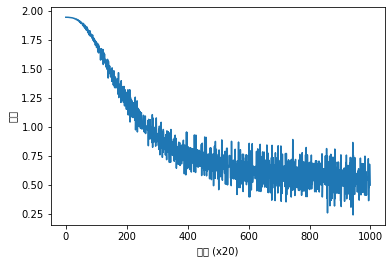

you [-1.3583277  1.0285021  0.8952027 -1.2033921 -1.0589424]
say [-0.19382268 -1.1903918  -1.1899948  -0.14734139  1.1623019 ]
goodbye [-0.5566405  0.7686114  0.8961107 -0.7623116 -0.722466 ]
and [-1.5858713  -1.0183074  -0.99184626  1.5865377   0.9587994 ]
i [-0.5592183   0.77433425  0.90696126 -0.77955276 -0.70981336]
hello [-1.3572443  1.0360253  0.8974397 -1.2066672 -1.0731809]
. [ 1.3442066 -0.9560322 -0.993817  -1.3983096  1.0223867]


In [ ]:
from common.trainer import Trainer
from common.optimizer import Adam

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# 말뭉치 전처리
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

# 맥락과 타겟으로 나누고 원핫벡터로 표현
vocab_size = len(word_to_id)
contexts, target = create_context_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# CBOW모델을 adam으로 훈련 객체 생성
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 훈련 및 플롯
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 단어 표현 벡터 확인
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word,word_vecs[word_id])


# 3.5 word2vec 보충



## 3.5.1 CBOW ㅁ